In [239]:
import cudf
import cuml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import umap.plot
import bokeh.plotting as bpl
from sklearn.preprocessing import LabelBinarizer
from matplotlib.gridspec import GridSpec
from cuml.manifold.umap import UMAP as clUMAP
from cuml.cluster import KMeans as cuKM
from cuml.decomposition import PCA as cuPCA
from sklearn.decomposition import PCA as skPCA
from sklearn.cluster import KMeans as skKM
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
class Helper:
    def __init__(self):
        """
        a dictionary, key is the sample name, value is a list which contains all the cnt matrices for the same
        sample
        """
        self.__sampleDicts = {}
        self.__tempDataFrame = None
        
        
    def __loadData(self, sampleName):
        """
        as the name, this function aims loading data into the program. 
        files must be stored in csv format, and each csv file contains one pair or more than one pairs of the counts of
        the samples. that means, a csv format must contain at least one of the real data's the counts and the counts of
        a simulated data which has been generated based on the read data.
    
        input:
        @sampleName: the name of the sample
    
        """
        cutOff = [0, 2.5, 5, 7.5, 10]
        # key of the tempDict is the cut off threshould, value is the cnt matrix accordingly
        
        dictList = []
        for cut in cutOff: 
            tempDict = {}
            fullPath = "/home/lima/Projects/simulation/SingleSample/Samples/{sampleName}WithReadsShorterThan{cut}cutOff.csv".format(sampleName = sampleName, cut = cut)
            dataFrame = pd.read_csv(fullPath)
            dataFrame = dataFrame.rename(columns = {"Unnamed: 0": "GeneID"})
            dataFrame.iloc[ : , 1 : ] = np.log2(dataFrame.iloc[ : , 1 : ] + 1)
            #print(dataFrame.isnull().values.any())
      
            tempDict[cut] = dataFrame
            dictList.append(tempDict)
        self.__sampleDicts[sampleName] = dictList
    
    def prepData(self):
        nameOptions = pd.read_csv("/home/lima/Projects/simulation/SingleSample/Option.csv", sep=" ", header = None)
        for index in range(len(nameOptions)):
            name = nameOptions.iloc[index, 0]
            print(name)
            self.__loadData(name)
            
    def getData(self):
        return self.__sampleDicts

In [3]:
helper = Helper()
helper.prepData()
samples = helper.getData()
keys = samples.keys()
keys = list(keys)

PDX_10Veh
PDX_12Veh
PDX_13P3_40
PDX_14P3_20
PDX_1P3_20
PDX_2P3_40
PDX_3P3_40
PDX_4P3_20
PDX_5P3_40
PDX_6P3_20
PDX_7P3_20
PDX_8Veh
PrimaryTumor


In [4]:
samples

{'PDX_10Veh': [{0:                 GeneID  PDX_10Veh  PDX_10Veh_Sim
   0      ENSG00000000003  11.989099      11.981069
   1      ENSG00000000005   3.661263       3.730407
   2      ENSG00000000419  10.842214      10.829813
   3      ENSG00000000457   8.444956       8.456131
   4      ENSG00000000460   8.504392       8.649672
   ...                ...        ...            ...
   57768  ENSG00000273487   3.777260       3.384140
   57769  ENSG00000273488   3.661263       3.829537
   57770  ENSG00000273489   4.603090       4.313341
   57771  ENSG00000273492   0.000000       0.000000
   57772  ENSG00000273493   0.000000       0.000000
   
   [57773 rows x 3 columns]},
  {2.5:                 GeneID  PDX_10Veh  PDX_10Veh_Sim
   0      ENSG00000000003  11.989790      11.980378
   1      ENSG00000000005   3.661900       3.729767
   2      ENSG00000000419  10.842905      10.829122
   3      ENSG00000000457   8.445645       8.455442
   4      ENSG00000000460   8.505081       8.648983
   ...   

In [5]:
highDose = set(['PDX_13P3_40', 'PDX_2P3_40', 'PDX_3P3_40', 'PDX_5P3_40'])
lowDose = set(['PDX_14P3_20', 'PDX_1P3_20', 'PDX_4P3_20', 'PDX_6P3_20', 'PDX_7P3_20'])
vehGrp = set(['PDX_8Veh', 'PDX_10Veh', 'PDX_12Veh'])
#vehGrp = set(['PDX_8Veh', 'PDX_10Veh'])
cutVal = [0, 2.5, 5, 7.5, 10]
tumor = set(['PrimaryTumor'])
high = []
low = []
veh = []
pt = []

In [6]:
for key in keys:
    tmpDF = samples.get(key)
    print(key)
    if key in highDose:
        high.append(tmpDF)
    elif key in lowDose:
        low.append(tmpDF)
    elif key in vehGrp:
        veh.append(tmpDF)
    else:
        pt.append(tmpDF)

PDX_10Veh
PDX_12Veh
PDX_13P3_40
PDX_14P3_20
PDX_1P3_20
PDX_2P3_40
PDX_3P3_40
PDX_4P3_20
PDX_5P3_40
PDX_6P3_20
PDX_7P3_20
PDX_8Veh
PrimaryTumor


In [7]:
"""
Prepare high dose treated data
"""

'\nPrepare high dose treated data\n'

In [8]:
cutVal = [0, 2.5, 5, 7.5, 10]
realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(high)):
    tmpDF = high[idx][0][cutVal[0]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF.fillna(0)

In [96]:
realDF['Treatment'] = 'High'
realDF['Source'] = 'Real'
simDF['Treatment'] = 'High'
simDF['Source'] = 'Simulated'
skpca = skPCA(n_components = 2)
decomposedDF = skpca.fit_transform(realDF.iloc[ : , 1 : 5])
dfR = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfR['Treatment'] = realDF.Treatment
dfR['Source'] = realDF.Source
decomposedDF = skpca.fit_transform(simDF.iloc[ : , 1 : 5])
dfS = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfS['Treatment'] = simDF.Treatment
dfS['Source'] = simDF.Source
hDF = [dfR, dfS]
hDF = pd.concat(hDF)

In [51]:
"""
Prepare the low dose treated data
"""

'\nPrepare the low dose treated data\n'

In [97]:
realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(low)):
    tmpDF = low[idx][0][cutVal[0]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF.fillna(0)

In [98]:
realDF['Treatment'] = 'Low'
realDF['Source'] = 'Real'
simDF['Treatment'] = 'Low'
simDF['Source'] = 'Simulated'
skpca = skPCA(n_components = 2)
decomposedDF = skpca.fit_transform(realDF.iloc[ : , 1 : 6])
dfR = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfR['Treatment'] = realDF.Treatment
dfR['Source'] = realDF.Source
decomposedDF = skpca.fit_transform(simDF.iloc[ : , 1 : 6])
dfS = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfS['Treatment'] = simDF.Treatment
dfS['Source'] = simDF.Source
lDF = [dfR, dfS]
lDF = pd.concat(lDF)

In [54]:
"""
Prepare the veh data
"""

'\nPrepare the veh data\n'

In [99]:
realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(veh)):
    tmpDF = veh[idx][0][cutVal[0]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF.fillna(0)

In [100]:
realDF['Treatment'] = 'Veh'
realDF['Source'] = 'Real'
simDF['Treatment'] = 'Veh'
simDF['Source'] = 'Simulated'
skpca = skPCA(n_components = 2)
decomposedDF = skpca.fit_transform(realDF.iloc[ : , 1 : 3])
dfR = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfR['Treatment'] = realDF.Treatment
dfR['Source'] = realDF.Source
decomposedDF = skpca.fit_transform(simDF.iloc[ : , 1 : 3])
dfS = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfS['Treatment'] = simDF.Treatment
dfS['Source'] = simDF.Source
vDF = [dfR, dfS]
vDF = pd.concat(vDF)

In [155]:
"""
realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(pt)):
    tmpDF = pt[idx][0][cutVal[0]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF.fillna(0)
"""

In [101]:
df = [hDF, lDF, vDF]
df = pd.concat(df)

In [102]:
df

,PC1,PC2,Treatment,Source
0,19.076693,-0.023022,High,Real
1,0.333759,-1.919465,High,Real
2,15.864020,-0.092298,High,Real
3,9.552742,-0.045352,High,Real
4,9.842843,0.149288,High,Real
...,...,...,...,...
57768,-0.942832,-1.270527,Veh,Simulated
57769,0.697334,-0.259653,Veh,Simulated
57770,0.578527,-1.062869,Veh,Simulated
57771,-4.456803,0.000898,Veh,Simulated


In [103]:
kDF = df[['PC1', 'PC2']]

In [104]:
%%time
kmeans = skKM(n_clusters = 4, random_state = 42)
kmeans.fit(kDF)

CPU times: user 8.59 s, sys: 7.76 s, total: 16.4 s
Wall time: 1.86 s


KMeans(n_clusters=4, random_state=42)

In [106]:
y_pred = kmeans.predict(kDF)
kDF['Predict'] = y_pred
kDF['Treatment'] = df['Treatment']
kDF['Label'] = kDF['Treatment'] + kDF['Predict'].astype(str)

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
classes = kDF.Label.unique()
classes = list(classes)
classes

['High2',
 'High3',
 'High1',
 'High0',
 'Low2',
 'Low3',
 'Low1',
 'Low0',
 'Veh1',
 'Veh3',
 'Veh0',
 'Veh2']

In [108]:
le = LabelEncoder()
Target = le.fit_transform(kDF.Label)
kDF['Target'] = Target

[]

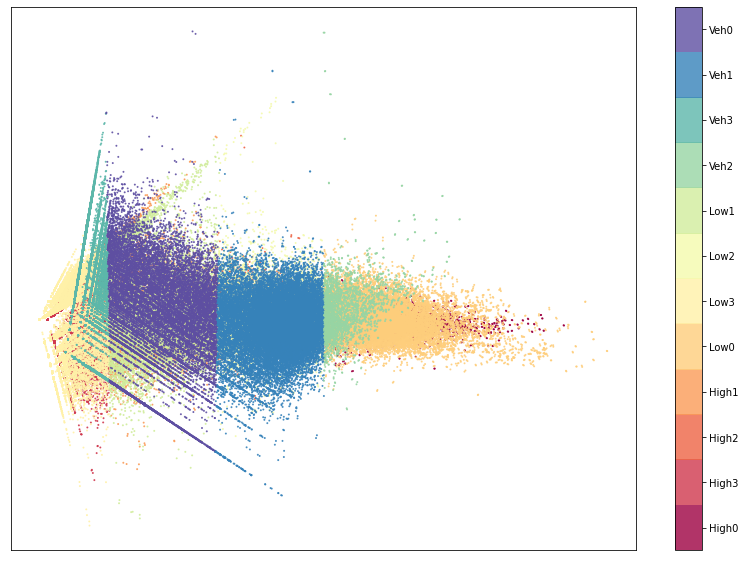

In [92]:
fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(kDF.PC1, kDF.PC2, c = kDF.Target, s = 1, cmap = 'Spectral', alpha = 0.8)
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(13) - 0.5)
cbar.set_ticks(np.arange(12))
cbar.set_ticklabels(classes)
plt.plot()

[]

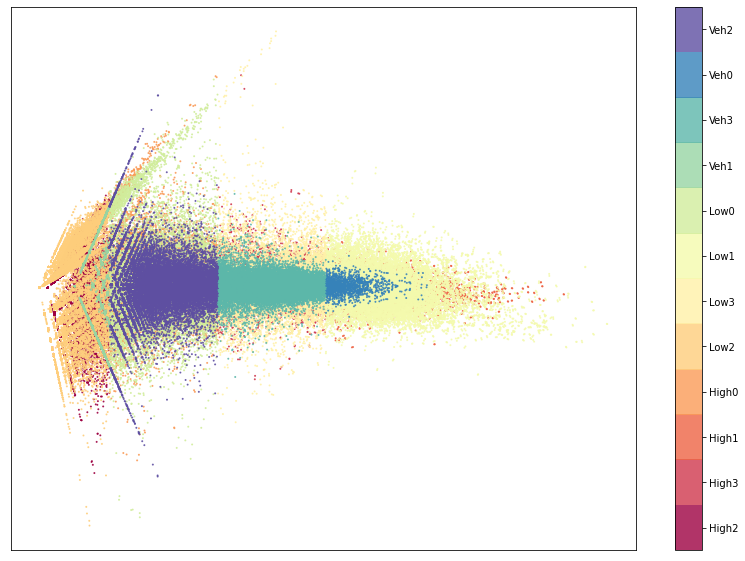

In [109]:
fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(kDF.PC1, kDF.PC2, c = kDF.Target, s = 1, cmap = 'Spectral', alpha = 0.8)
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(13) - 0.5)
cbar.set_ticks(np.arange(12))
cbar.set_ticklabels(classes)
plt.plot()

In [130]:

realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(high)):
    tmpDF = high[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF = realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF = simDF.fillna(0)

NaNs were detected in real data
Fill NaNs with zeros
NaNs were detected in simulated data
Fill NaNs with zeros


In [131]:
realDF

,GeneID,PDX_13P3_40,PDX_2P3_40,PDX_3P3_40,PDX_5P3_40
0,ENSG00000000003,12.644603,12.932763,12.476348,13.199729
1,ENSG00000000005,5.035545,2.890276,2.072945,3.780346
2,ENSG00000000419,11.119964,11.308080,10.959784,11.443734
3,ENSG00000000457,7.992755,8.314974,8.064424,7.843285
4,ENSG00000000460,7.954595,8.470076,8.198894,8.167754
...,...,...,...,...,...
26365,ENSG00000273167,0.000000,0.000000,0.000000,3.075852
26366,ENSG00000273214,0.000000,0.000000,0.000000,2.391432
26367,ENSG00000273341,0.000000,0.000000,0.000000,2.881698
26368,ENSG00000273433,0.000000,0.000000,0.000000,1.643113


In [132]:
realDF['Treatment'] = 'High'
realDF['Source'] = 'Real'
simDF['Treatment'] = 'High'
simDF['Source'] = 'Simulated'
skpca = skPCA(n_components = 2)
decomposedDF = skpca.fit_transform(realDF.iloc[ : , 1 : 5])
dfR = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfR['Treatment'] = realDF.Treatment
dfR['Source'] = realDF.Source
decomposedDF = skpca.fit_transform(simDF.iloc[ : , 1 : 5])
dfS = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfS['Treatment'] = simDF.Treatment
dfS['Source'] = simDF.Source
hDF = [dfR, dfS]
hDF = pd.concat(hDF)

In [133]:
realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(low)):
    tmpDF = low[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF = realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF = simDF.fillna(0)

NaNs were detected in real data
Fill NaNs with zeros
NaNs were detected in simulated data
Fill NaNs with zeros


In [134]:
realDF['Treatment'] = 'Low'
realDF['Source'] = 'Real'
simDF['Treatment'] = 'Low'
simDF['Source'] = 'Simulated'
skpca = skPCA(n_components = 2)
decomposedDF = skpca.fit_transform(realDF.iloc[ : , 1 : 6])
dfR = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfR['Treatment'] = realDF.Treatment
dfR['Source'] = realDF.Source
decomposedDF = skpca.fit_transform(simDF.iloc[ : , 1 : 6])
dfS = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfS['Treatment'] = simDF.Treatment
dfS['Source'] = simDF.Source
lDF = [dfR, dfS]
lDF = pd.concat(lDF)

In [135]:
realDF = pd.DataFrame()
simDF = pd.DataFrame()
for idx in range(len(veh)):
    tmpDF = veh[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realDF.empty:
        realDF = tmpRl
    else:
        realDF = pd.merge(realDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simDF.empty:
        simDF = tmpSim
    else:
        simDF = pd.merge(simDF, tmpSim, on = 'GeneID', how = 'outer')
    
if realDF.isnull().values.any() == True:
    print('NaNs were detected in real data')
    print('Fill NaNs with zeros')
    realDF = realDF.fillna(0)

if simDF.isnull().values.any() == True:
    print('NaNs were detected in simulated data')
    print('Fill NaNs with zeros')
    simDF = simDF.fillna(0)

NaNs were detected in real data
Fill NaNs with zeros
NaNs were detected in simulated data
Fill NaNs with zeros


In [136]:
realDF['Treatment'] = 'Veh'
realDF['Source'] = 'Real'
simDF['Treatment'] = 'Veh'
simDF['Source'] = 'Simulated'
skpca = skPCA(n_components = 2)
decomposedDF = skpca.fit_transform(realDF.iloc[ : , 1 : 3])
dfR = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfR['Treatment'] = realDF.Treatment
dfR['Source'] = realDF.Source
decomposedDF = skpca.fit_transform(simDF.iloc[ : , 1 : 3])
dfS = pd.DataFrame(decomposedDF, columns = ['PC1', 'PC2'])
dfS['Treatment'] = simDF.Treatment
dfS['Source'] = simDF.Source
vDF = [dfR, dfS]
vDF = pd.concat(vDF)

In [151]:
df = [hDF, lDF, vDF]
df = pd.concat(df)
kDF = df[['PC1', 'PC2']]

In [152]:
%%time
kmeans = skKM(n_clusters = 13, random_state = 42)
kmeans.fit(kDF)

CPU times: user 18.4 s, sys: 9.52 s, total: 28 s
Wall time: 4.28 s


KMeans(n_clusters=13, random_state=42)

In [153]:
y_pred = kmeans.predict(kDF)
kDF['Predict'] = y_pred
kDF['Treatment'] = df['Treatment']
#kDF['Label'] = kDF['Treatment'] + kDF['Predict'].astype(str)

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
classes = kDF.Predict.unique()
classes = list(classes)

In [156]:
le = LabelEncoder()
Target = le.fit_transform(kDF.Predict)
kDF['Target'] = Target

[]

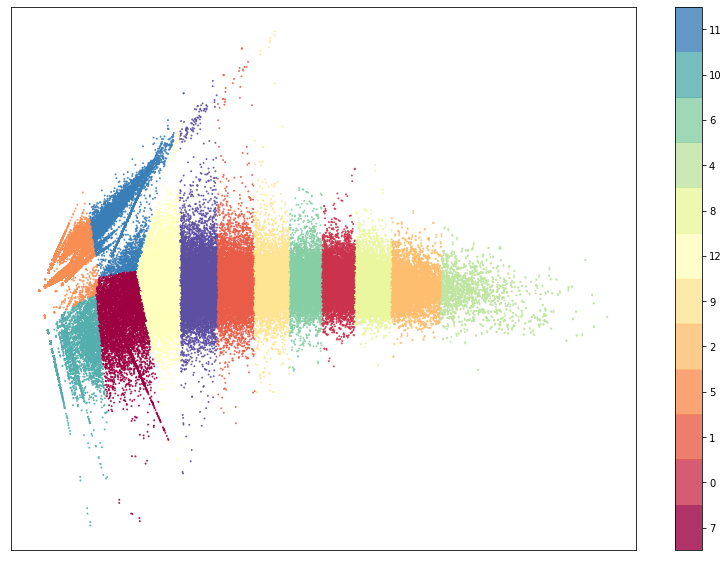

In [157]:
fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(kDF.PC1, kDF.PC2, c = kDF.Target, s = 1, cmap = 'Spectral', alpha = 0.8)
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(13) - 0.5)
cbar.set_ticks(np.arange(12))
cbar.set_ticklabels(classes)
plt.plot()

In [9]:
realHDF = pd.DataFrame()
simHDF = pd.DataFrame()
for idx in range(len(high)):
    tmpDF = high[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realHDF.empty:
        realHDF = tmpRl
    else:
        realHDF = pd.merge(realHDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simHDF.empty:
        simHDF = tmpSim
    else:
        simHDF = pd.merge(simHDF, tmpSim, on = 'GeneID', how = 'outer')

In [10]:
realLDF = pd.DataFrame()
simLDF = pd.DataFrame()
for idx in range(len(low)):
    tmpDF = low[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    if realLDF.empty:
        realLDF = tmpRl
    else:
        realLDF = pd.merge(realLDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simLDF.empty:
        simLDF = tmpSim
    else:
        simLDF = pd.merge(simLDF, tmpSim, on = 'GeneID', how = 'outer')

In [11]:
realVDF = pd.DataFrame()
simVDF = pd.DataFrame()
for idx in range(len(veh)):
    tmpDF = veh[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realVDF.empty:
        realVDF = tmpRl
    else:
        realVDF = pd.merge(realVDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simVDF.empty:
        simVDF = tmpSim
    else:
        simVDF = pd.merge(simVDF, tmpSim, on = 'GeneID', how = 'outer')

In [12]:
realTDF = pd.DataFrame()
simTDF = pd.DataFrame()
for idx in range(len(pt)):
    tmpDF = pt[idx][2][cutVal[2]]
    
    tmpRl = tmpDF.iloc[ : , [0, 1]]
    tmpSim = tmpDF.iloc[ : , [0 , 2]]
    
    if realTDF.empty:
        realTDF = tmpRl
    else:
        realTDF = pd.merge(realTDF, tmpRl, on = 'GeneID', how = 'outer')
        
    if simTDF.empty:
        simTDF = tmpSim
    else:
        simTDF = pd.merge(simTDF, tmpSim, on = 'GeneID', how = 'outer')

In [13]:
realTDF

,GeneID,PrimaryTumor
0,ENSG00000000003,11.993052
1,ENSG00000000419,9.149615
2,ENSG00000000457,9.266770
3,ENSG00000000460,9.400734
4,ENSG00000000938,9.388861
...,...,...
26576,ENSG00000273483,3.459432
26577,ENSG00000273485,2.584963
26578,ENSG00000273486,6.491853
26579,ENSG00000273488,5.614710


In [14]:
totalReal = pd.merge(realHDF, realLDF, on = 'GeneID', how = 'outer')
totalReal = pd.merge(totalReal, realVDF, on = 'GeneID', how = 'outer')
totalReal = pd.merge(totalReal, realTDF, on = 'GeneID', how = 'outer')

In [15]:
totalSim = pd.merge(simHDF, simLDF, on = 'GeneID', how = 'outer')
totalSim = pd.merge(totalSim, simVDF, on = 'GeneID', how = 'outer')
totalSim = pd.merge(totalSim, simTDF, on = 'GeneID', how = 'outer')

In [15]:
totalReal

,GeneID,PDX_13P3_40,PDX_2P3_40,PDX_3P3_40,PDX_5P3_40,PDX_14P3_20,PDX_1P3_20,PDX_4P3_20,PDX_6P3_20,PDX_7P3_20,PDX_10Veh,PDX_12Veh,PDX_8Veh,PrimaryTumor
0,ENSG00000000003,12.644603,12.932763,12.476348,13.199729,12.305841,11.843860,12.952072,12.518251,12.394169,11.990086,7.157256,12.602008,11.993052
1,ENSG00000000005,5.035545,2.890276,2.072945,3.780346,3.914644,2.663742,3.080001,2.807355,3.169925,3.662173,2.396343,4.169925,NaN
2,ENSG00000000419,11.119964,11.308080,10.959784,11.443734,10.744114,10.345231,11.627484,11.089429,10.774062,10.843201,5.964378,10.918751,9.149615
3,ENSG00000000457,7.992755,8.314974,8.064424,7.843285,7.591744,8.235452,7.903586,8.200536,8.503514,8.445940,5.633217,7.880120,9.266770
4,ENSG00000000460,7.954595,8.470076,8.198894,8.167754,8.516182,8.783810,8.301530,8.649219,8.715629,8.505377,4.895467,7.808689,9.400734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41144,ENSG00000273085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.807355
41145,ENSG00000273160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.700440
41146,ENSG00000273213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584963
41147,ENSG00000273269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


In [16]:
totalSim

,GeneID,PDX_13P3_40_Sim,PDX_2P3_40_Sim,PDX_3P3_40_Sim,PDX_5P3_40_Sim,PDX_14P3_20_Sim,PDX_1P3_20_Sim,PDX_4P3_20_Sim,PDX_6P3_20_Sim,PDX_7P3_20_Sim,PDX_10Veh_Sim,PDX_12Veh_Sim,PDX_8Veh_Sim,PrimaryTumor_Sim
0,ENSG00000000003,12.666604,12.913990,12.455690,13.219199,12.334511,11.795736,12.955291,12.524459,12.401437,11.980082,7.200628,12.613090,11.959926
1,ENSG00000000005,5.006021,2.505174,2.505032,3.620901,3.992214,1.930056,3.722979,2.321928,3.459432,3.729494,2.248461,4.247928,NaN
2,ENSG00000000419,11.124364,11.313727,10.927380,11.454913,10.840911,10.271296,11.685530,11.049851,10.777157,10.828826,6.025939,10.910013,9.121666
3,ENSG00000000457,8.119763,8.271433,7.950863,7.887862,7.745337,8.230509,7.978212,8.149161,8.418956,8.455147,5.728538,7.764073,9.301676
4,ENSG00000000460,8.000217,8.343183,8.120480,8.111514,8.406291,8.716755,8.251984,8.634610,8.667756,8.648687,4.717537,7.779878,9.451720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41144,ENSG00000273085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.321928
41145,ENSG00000273160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.321928
41146,ENSG00000273213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.584963
41147,ENSG00000273269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


In [17]:
total = pd.merge(totalReal, totalSim, on = 'GeneID', how = 'outer')

In [18]:
total

,GeneID,PDX_13P3_40,PDX_2P3_40,PDX_3P3_40,PDX_5P3_40,PDX_14P3_20,PDX_1P3_20,PDX_4P3_20,PDX_6P3_20,PDX_7P3_20,...,PDX_5P3_40_Sim,PDX_14P3_20_Sim,PDX_1P3_20_Sim,PDX_4P3_20_Sim,PDX_6P3_20_Sim,PDX_7P3_20_Sim,PDX_10Veh_Sim,PDX_12Veh_Sim,PDX_8Veh_Sim,PrimaryTumor_Sim
0,ENSG00000000003,12.644603,12.932763,12.476348,13.199729,12.305841,11.843860,12.952072,12.518251,12.394169,...,13.219199,12.334511,11.795736,12.955291,12.524459,12.401437,11.980082,7.200628,12.613090,11.959926
1,ENSG00000000005,5.035545,2.890276,2.072945,3.780346,3.914644,2.663742,3.080001,2.807355,3.169925,...,3.620901,3.992214,1.930056,3.722979,2.321928,3.459432,3.729494,2.248461,4.247928,NaN
2,ENSG00000000419,11.119964,11.308080,10.959784,11.443734,10.744114,10.345231,11.627484,11.089429,10.774062,...,11.454913,10.840911,10.271296,11.685530,11.049851,10.777157,10.828826,6.025939,10.910013,9.121666
3,ENSG00000000457,7.992755,8.314974,8.064424,7.843285,7.591744,8.235452,7.903586,8.200536,8.503514,...,7.887862,7.745337,8.230509,7.978212,8.149161,8.418956,8.455147,5.728538,7.764073,9.301676
4,ENSG00000000460,7.954595,8.470076,8.198894,8.167754,8.516182,8.783810,8.301530,8.649219,8.715629,...,8.111514,8.406291,8.716755,8.251984,8.634610,8.667756,8.648687,4.717537,7.779878,9.451720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41144,ENSG00000273085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.321928
41145,ENSG00000273160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.321928
41146,ENSG00000273213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.584963
41147,ENSG00000273269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


In [19]:
total = total.fillna(0)

In [20]:
total

,GeneID,PDX_13P3_40,PDX_2P3_40,PDX_3P3_40,PDX_5P3_40,PDX_14P3_20,PDX_1P3_20,PDX_4P3_20,PDX_6P3_20,PDX_7P3_20,...,PDX_5P3_40_Sim,PDX_14P3_20_Sim,PDX_1P3_20_Sim,PDX_4P3_20_Sim,PDX_6P3_20_Sim,PDX_7P3_20_Sim,PDX_10Veh_Sim,PDX_12Veh_Sim,PDX_8Veh_Sim,PrimaryTumor_Sim
0,ENSG00000000003,12.644603,12.932763,12.476348,13.199729,12.305841,11.843860,12.952072,12.518251,12.394169,...,13.219199,12.334511,11.795736,12.955291,12.524459,12.401437,11.980082,7.200628,12.613090,11.959926
1,ENSG00000000005,5.035545,2.890276,2.072945,3.780346,3.914644,2.663742,3.080001,2.807355,3.169925,...,3.620901,3.992214,1.930056,3.722979,2.321928,3.459432,3.729494,2.248461,4.247928,0.000000
2,ENSG00000000419,11.119964,11.308080,10.959784,11.443734,10.744114,10.345231,11.627484,11.089429,10.774062,...,11.454913,10.840911,10.271296,11.685530,11.049851,10.777157,10.828826,6.025939,10.910013,9.121666
3,ENSG00000000457,7.992755,8.314974,8.064424,7.843285,7.591744,8.235452,7.903586,8.200536,8.503514,...,7.887862,7.745337,8.230509,7.978212,8.149161,8.418956,8.455147,5.728538,7.764073,9.301676
4,ENSG00000000460,7.954595,8.470076,8.198894,8.167754,8.516182,8.783810,8.301530,8.649219,8.715629,...,8.111514,8.406291,8.716755,8.251984,8.634610,8.667756,8.648687,4.717537,7.779878,9.451720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41144,ENSG00000273085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.321928
41145,ENSG00000273160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.321928
41146,ENSG00000273213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.584963
41147,ENSG00000273269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000


In [21]:
total = total.drop(columns = 'GeneID')
total = total.T
total

,0,1,2,3,4,5,6,7,8,9,...,41139,41140,41141,41142,41143,41144,41145,41146,41147,41148
PDX_13P3_40,12.644603,5.035545,11.119964,7.992755,7.954595,6.144759,11.006630,11.891951,11.293484,12.053856,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_2P3_40,12.932763,2.890276,11.308080,8.314974,8.470076,7.439016,11.574365,11.900313,11.850309,11.874668,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_3P3_40,12.476348,2.072945,10.959784,8.064424,8.198894,6.533483,11.340923,11.898162,11.716889,12.209355,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_5P3_40,13.199729,3.780346,11.443734,7.843285,8.167754,7.374347,11.240615,12.200215,11.996222,12.344910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_14P3_20,12.305841,3.914644,10.744114,7.591744,8.516182,7.315260,11.038350,11.830278,11.476115,12.258422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_1P3_20,11.843860,2.663742,10.345231,8.235452,8.783810,6.321637,11.293670,12.112757,9.545509,10.837131,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_4P3_20,12.952072,3.080001,11.627484,7.903586,8.301530,6.927197,11.763359,12.025936,11.624644,11.999762,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_6P3_20,12.518251,2.807355,11.089429,8.200536,8.649219,7.010667,11.295160,12.057391,11.767484,12.285554,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_7P3_20,12.394169,3.169925,10.774062,8.503514,8.715629,6.265427,11.579632,12.137464,11.895726,12.550044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
PDX_10Veh,11.990086,3.662173,10.843201,8.445940,8.505377,6.589463,10.831805,11.323848,11.315449,12.133441,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [179]:
totalTarget = total.index.values.tolist()
sourceTarget = ['Real'] * 13 + ['Simulated'] * 13
groupTarget = ['High'] * 4 + ['Low'] * 5 + ['Veh'] * 3 + ['Tumor'] + ['High'] * 4 + ['Low'] * 5 + ['Veh'] * 3 + ['Tumor']

In [180]:
encoder = LabelEncoder()
lbEncoder = LabelBinarizer()
SourceLabel = lbEncoder.fit_transform(sourceTarget)
GroupLabel = encoder.fit_transform(groupTarget)

In [183]:
groupTarget

['High',
 'High',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Veh',
 'Veh',
 'Veh',
 'Tumor',
 'High',
 'High',
 'High',
 'High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Veh',
 'Veh',
 'Veh',
 'Tumor']

In [181]:
GroupLabel

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       3, 3, 3, 2])

In [26]:
%%time
pca = skPCA(n_components = 2)
decomposedTotal = pca.fit_transform(total)

CPU times: user 589 ms, sys: 679 ms, total: 1.27 s
Wall time: 281 ms


In [92]:
decomposedDF = pd.DataFrame(decomposedTotal, columns = (['PC1', 'PC2']))
encoder = LabelEncoder()
Label = encoder.fit_transform(totalTarget)
decomposedDF['Label'] = Label
decomposedDF

,PC1,PC2,Label
0,-75.228579,-26.118465,4
1,-90.399238,-6.963195,10
2,-69.550358,-16.427229,12
3,-95.495107,-9.097859,16
4,-102.120283,-14.393029,6
5,-38.874688,-67.358297,8
6,-90.228526,-15.261440,14
7,-86.864623,-16.051959,18
8,-64.612683,-11.082856,20
9,-67.020072,-22.666075,0


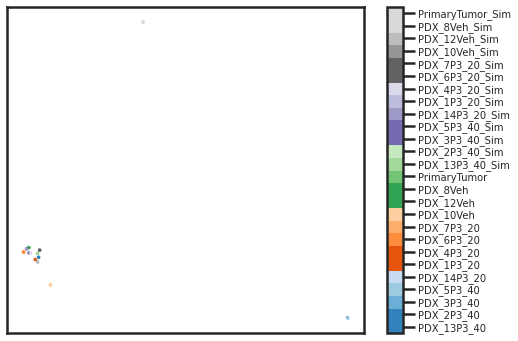

In [98]:
#sns.set(style='white', context='poster')
fig, ax6 = plt.subplots(1, figsize = (8, 6))
plt.scatter(x = 'PC1', y = 'PC2', c = 'Label', cmap = 'tab20c', s = 2.0, alpha = 1.0, data = decomposedDF)
plt.setp(ax6, xticks = [], yticks = [])
#plt.legend(loc = 'best', prop = {'size': 10})
cbar = plt.colorbar(boundaries = np.arange(27) - 0.5)
cbar.set_ticks(np.arange(26))
cbar.ax.tick_params(labelsize = 10)
cbar.set_ticklabels(totalTarget)

In [211]:
%%time
embedding = umap.UMAP(n_neighbors = 3).fit_transform(total)

CPU times: user 2.05 s, sys: 12.7 ms, total: 2.06 s
Wall time: 1.73 s


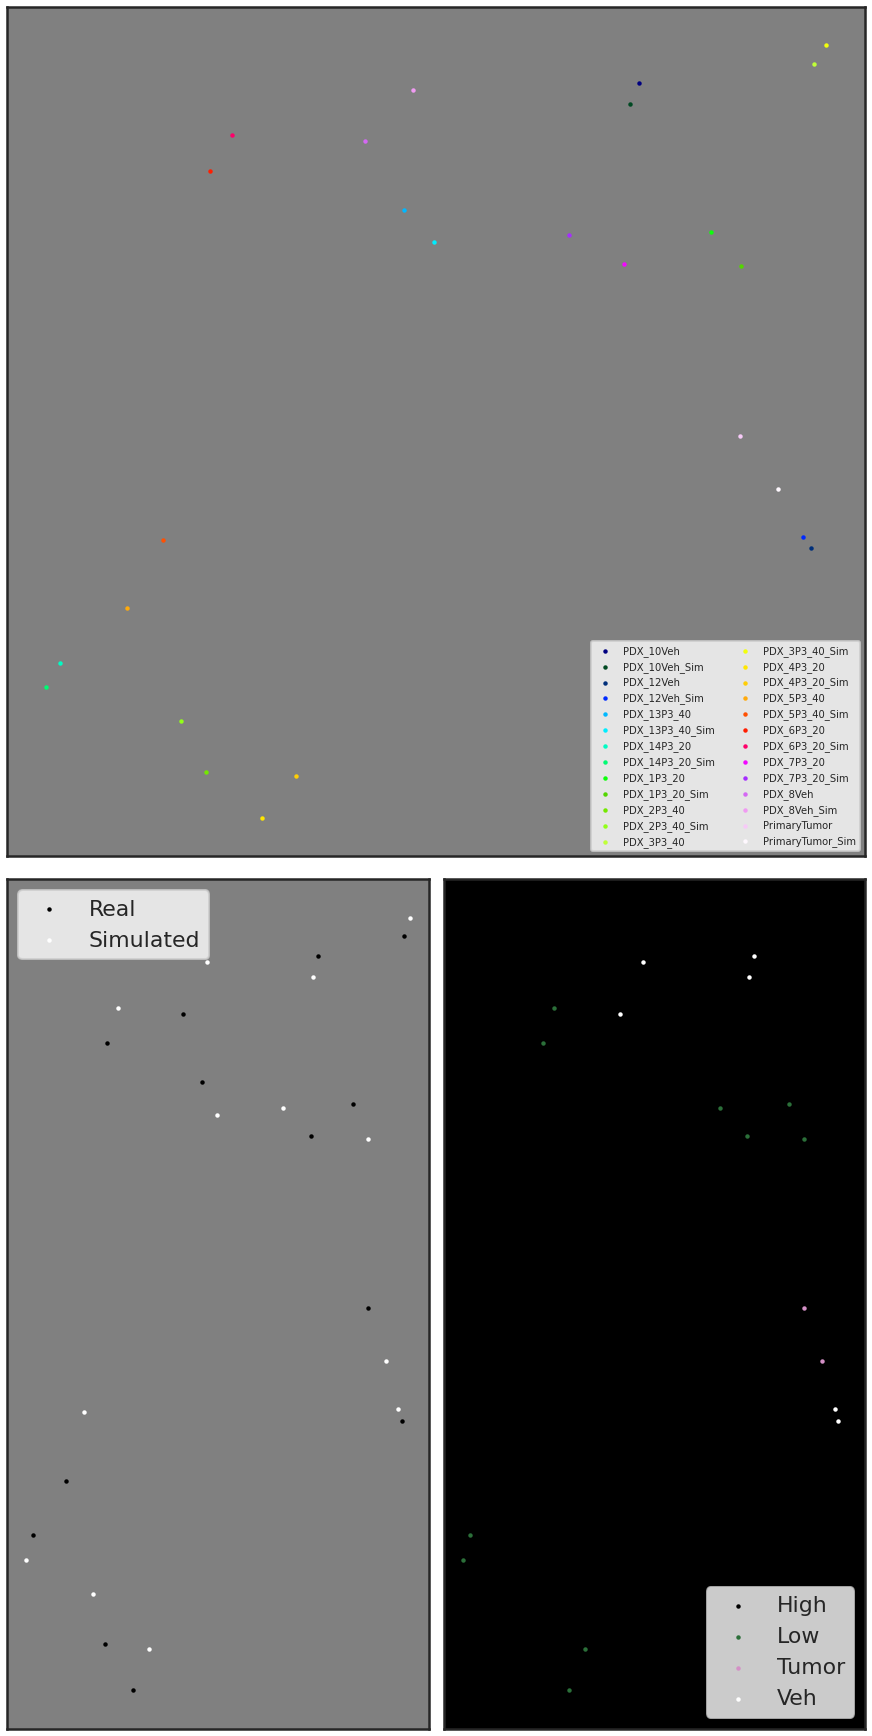

In [242]:
embDF = pd.DataFrame(embedding, columns = (['PC1', 'PC2']))
embDF['Label'] = totalTarget
embDF['GroupLabel'] = groupTarget
embDF['SourceLabel'] = sourceTarget

labCat = np.unique(embDF['Label'])
labColors = [plt.cm.gist_ncar(i / float(len(labCat) - 1)) for i in range(len(labCat))]

grpCat = np.unique(embDF['GroupLabel'])
grpColors = [plt.cm.cubehelix(i / float(len(grpCat) - 1)) for i in range(len(grpCat))]

srcCat = np.unique(embDF['SourceLabel'])
srcColors = [plt.cm.cubehelix(i / float(len(srcCat) - 1)) for i in range(len(srcCat))]

# fig, ax = plt.subplots(2, 2, figsize = (36, 8))
fig = plt.figure(constrained_layout = True, figsize = (12, 24))
gs = GridSpec(2, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, : ])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.set_facecolor('gray')
#ax[0].scatter(x = 'PC1', y = 'PC2', s = 6, c = 'Label', cmap = plt.cm.get_cmap('gist_ncar', 26), alpha = 1.0, legend = True, data = embDF)
plt.setp(ax1, xticks = [], yticks = [])

for i, category in enumerate(labCat):
    ax1.scatter('PC1', 'PC2', 
                data = embDF.loc[embDF.Label == category, :], 
                s = 6, c = labColors[i], label = str(category))
ax1.legend(loc = 'best', ncol = 2, fontsize = 10)
#cbar1 = fig.colorbar(boundaries = np.arange(27) - 0.5, ax = ax[0])
#cbar1.set_ticks(np.arange(26))
#cbar1.ax.tick_params(labelsize = 10)
#cbar1.set_ticklabels(totalTarget)

ax2.set_facecolor('gray')
#ax[1].scatter(x = 'PC1', y = 'PC2', s = 6, c = 'SourceLabel', cmap = plt.cm.get_cmap('cubehelix', 2), alpha = 1.0, data = embDF)
plt.setp(ax2, xticks = [], yticks = [])

for i, category in enumerate(srcCat):
    ax2.scatter('PC1', 'PC2', 
                data = embDF.loc[embDF.SourceLabel == category, :], 
                s = 6, c = srcColors[i], label = str(category))
ax2.legend(loc = 'best', fontsize = 8)
#cbar2 = fig.colorbar(boundaries = np.arange(3) - 0.5, ax = ax[1])
#cbar2.set_ticks(np.arange(2))
#cbar2.ax.tick_params(labelsize = 10)
#cbar2.set_ticklabels(list(set(sourceTarget)))


ax3.set_facecolor('black')
#ax[2].scatter(x = 'PC1', y = 'PC2', s = 6, c = 'SourceLabel', cmap = plt.cm.get_cmap('gist_ncar', 4), alpha = 1.0, data = embDF)
plt.setp(ax3, xticks = [], yticks = [])

for i, category in enumerate(grpCat):
    ax3.scatter('PC1', 'PC2', 
                data = embDF.loc[embDF.GroupLabel == category, :], 
                s = 6, c = grpColors[i], label = str(category))
ax3.legend(loc = 'best', fontsize = 8)

#cbar3 = fig.colorbar(boundaries = np.arange(5) - 0.5, ax = ax[2])
#cbar3.set_ticks(np.arange(4))
#cbar3.ax.tick_params(labelsize = 10)
#cbar3.set_ticklabels(['Hihg', 'Low', 'Tumor', 'Veh'])

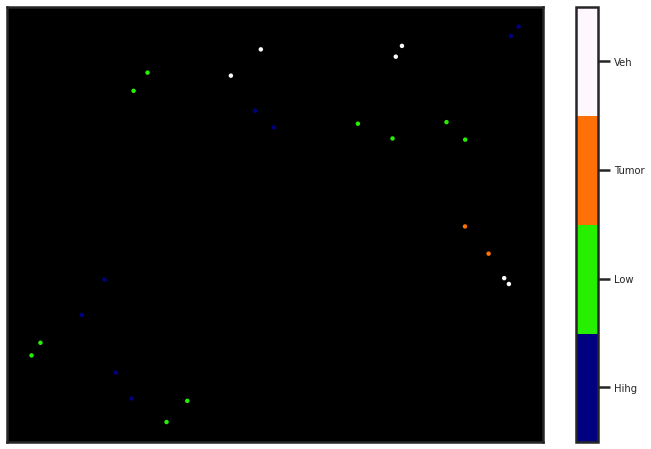

In [16]:
tmpReal = totalReal.fillna(0)
tmpReal.drop(columns = "GeneID")
real_mean = tmpReal.mean(axis = 1)
real_var = tmpReal.var(axis = 1)
real_std = tmpReal.std(axis = 1)

In [17]:
nonInTumor = totalReal[pd.isnull(totalReal['PrimaryTumor'])]
#nonInTumorH = nonInTumor.iloc[ : , 0 : 5]
#nonInTumorL = nonInTumor.iloc[ : , [0, 5, 6, 7, 8 ,9]]
#nonInTumorV = nonInTumor.iloc[ : , [0, 10, 11, 12]]
nonInTumor = nonInTumor.drop(columns = 'PrimaryTumor')

In [18]:
totalNan = nonInTumor.isnull().sum(axis = 1)
nonInTumor['TotalNan'] = totalNan

In [19]:
tmpH = nonInTumor.iloc[ : , 0 : 5]
tmpL = nonInTumor.iloc[ : , [0, 5, 6, 7, 8 ,9]]
tmpV = nonInTumor.iloc[ : , [0, 10, 11, 12]]
tmpH['TotalNan'] = tmpH.isnull().sum(axis = 1)
tmpL['TotalNan'] = tmpL.isnull().sum(axis = 1)
tmpV['TotalNan'] = tmpV.isnull().sum(axis = 1)

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
notInTumorAndH = set(tmpH[tmpH['TotalNan'] >= 3].index)
notInTumorMaybeInH = set(tmpH[tmpH['TotalNan'] < 3].index)
notInTumorAndL = set(tmpL[tmpL['TotalNan'] >= 4].index)
notInTumorMaybeInL = set(tmpL[tmpL['TotalNan'] < 4].index)
notInTumorAndVeh = set(tmpV[tmpV['TotalNan'] > 2].index)
notInTumorMaybeInVeh = set(tmpV[tmpV['TotalNan'] <= 2].index)

In [21]:
notInTumorAndTreated = notInTumorAndH | notInTumorAndL | notInTumorAndVeh

In [22]:
notInTumorButH = notInTumorMaybeInH - (notInTumorMaybeInL | notInTumorMaybeInVeh)
notInTumorButL = notInTumorMaybeInL - (notInTumorMaybeInH | notInTumorMaybeInVeh)
notInTumorButVeh = notInTumorMaybeInVeh - (notInTumorMaybeInL | notInTumorMaybeInH)

In [23]:
onlyH = list(notInTumorButH)
onlyL = list(notInTumorButL)
onlyV = list(notInTumorButVeh)

In [24]:
inTumor = totalReal[pd.isnull(totalReal['PrimaryTumor']) == False]
inTumor = inTumor.drop(columns = 'PrimaryTumor')
inTumor['TotalNan'] = inTumor.isnull().sum(axis = 1)
tumorOnly = inTumor[inTumor['TotalNan'] >= 9].index
tumorOnly = list(tumorOnly)

In [25]:
plotIdx = (notInTumorButH | notInTumorButL | notInTumorButVeh | set(tumorOnly))
plotIdx = list(plotIdx)
plotDF = totalReal.iloc[plotIdx, : ]
plotDF['Source'] = "Tumor"
plotDF.loc[onlyH, 'Source'] = 'HighDose'
plotDF.loc[onlyL, 'Source'] = 'LowDose'
plotDF.loc[onlyV, 'Source'] = 'Veh'

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
pltDF = plotDF.iloc[ : , 1 : ]
pltDF = pltDF.fillna(0)

In [27]:
tmp = pltDF.drop(columns = 'Source')
target = np.array(pltDF.Source, dtype = np.str)
le = LabelEncoder()
target = le.fit_transform(target)
classes = ['HighDose', 'LowDose', 'Tumor', 'Veh']

In [28]:
%%time
embedding = umap.UMAP(n_neighbors = 15).fit_transform(tmp)

CPU times: user 2min 43s, sys: 53.4 s, total: 3min 36s
Wall time: 24 s


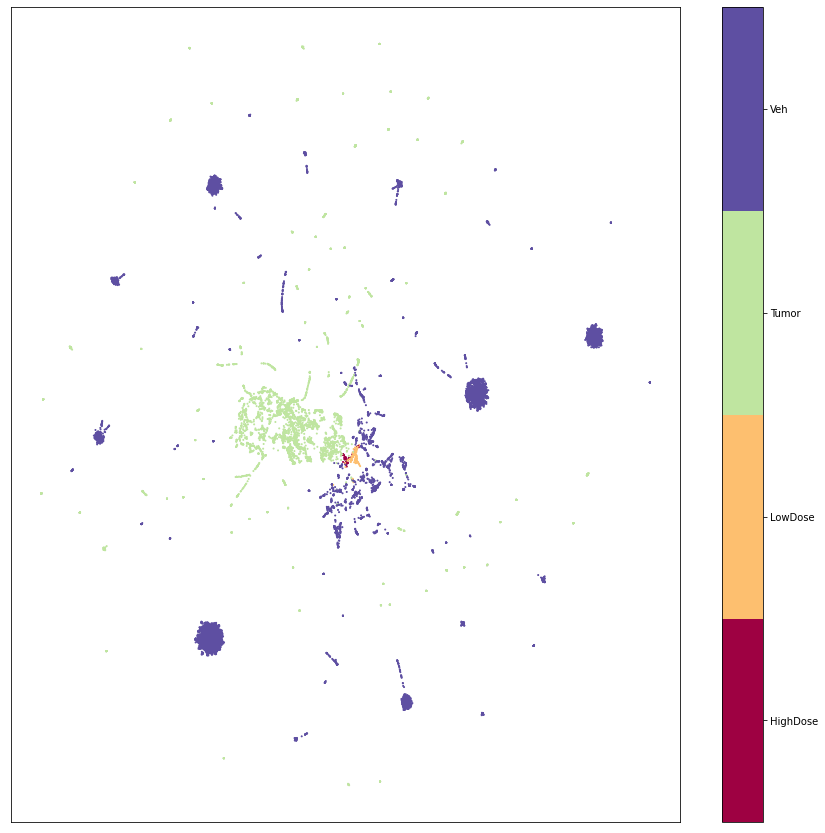

In [29]:
fig1, ax1 = plt.subplots(1, figsize = (15, 15))
plt.scatter(*embedding.T, s = 1, c = target, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax1, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(5) - 0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)

In [30]:
nonInSimTumor = totalSim[pd.isnull(totalSim['PrimaryTumor_Sim'])]
#nonInSimTumorH = nonInSimTumor.iloc[ : , 0 : 5]
#nonInSimTumorL = nonInSimTumor.iloc[ : , [0, 5, 6, 7, 8 ,9]]
#nonInSimTumorV = nonInSimTumor.iloc[ : , [0, 10, 11, 12]]
nonInSimTumor = nonInSimTumor.drop(columns = 'PrimaryTumor_Sim')

In [31]:
totalSimNan = nonInSimTumor.isnull().sum(axis = 1)
nonInSimTumor['TotalNan'] = totalSimNan

In [32]:
tmpSimH = nonInSimTumor.iloc[ : , 0 : 5]
tmpSimL = nonInSimTumor.iloc[ : , [0, 5, 6, 7, 8 ,9]]
tmpSimV = nonInSimTumor.iloc[ : , [0, 10, 11, 12]]
tmpSimH['TotalNan'] = tmpSimH.isnull().sum(axis = 1)
tmpSimL['TotalNan'] = tmpSimL.isnull().sum(axis = 1)
tmpSimV['TotalNan'] = tmpSimV.isnull().sum(axis = 1)

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
tmpSimV

,GeneID,PDX_10Veh_Sim,PDX_12Veh_Sim,PDX_8Veh_Sim,TotalNan
1,ENSG00000000005,3.729494,2.248461,4.247928,0
133,ENSG00000006611,NaN,1.676488,NaN,2
160,ENSG00000007314,5.631501,6.142765,4.459240,0
296,ENSG00000013293,NaN,7.565740,2.000000,1
332,ENSG00000015592,2.255101,3.414751,2.585571,0
...,...,...,...,...,...
40178,ENSG00000265907,NaN,NaN,1.584963,2
40180,ENSG00000269855,NaN,NaN,2.321928,2
40181,ENSG00000270134,NaN,NaN,1.584963,2
40182,ENSG00000270521,NaN,NaN,1.584963,2


In [34]:
notInSimTumorAndH = set(tmpSimH[tmpSimH['TotalNan'] >= 3].index)
notInSimTumorMaybeInH = set(tmpSimH[tmpSimH['TotalNan'] < 3].index)
notInSimTumorAndL = set(tmpSimL[tmpSimL['TotalNan'] >= 4].index)
notInSimTumorMaybeInL = set(tmpSimL[tmpSimL['TotalNan'] < 4].index)
notInSimTumorAndVeh = set(tmpSimV[tmpSimV['TotalNan'] > 2].index)
notInSimTumorMaybeInVeh = set(tmpSimV[tmpSimV['TotalNan'] <= 2].index)

In [35]:
notInSimTumorAndTreated = notInSimTumorAndH | notInSimTumorAndL | notInSimTumorAndVeh

In [36]:
notInSimTumorButH = notInSimTumorMaybeInH - (notInSimTumorMaybeInL | notInSimTumorMaybeInVeh)
notInSimTumorButL = notInSimTumorMaybeInL - (notInSimTumorMaybeInH | notInSimTumorMaybeInVeh)
notInSimTumorButVeh = notInSimTumorMaybeInVeh - (notInSimTumorMaybeInL | notInSimTumorMaybeInH)

In [37]:
onlySimH = list(notInSimTumorButH)
onlySimL = list(notInSimTumorButL)
onlySimV = list(notInSimTumorButVeh)

In [38]:
inSimTumor = totalSim[pd.isnull(totalSim['PrimaryTumor_Sim']) == False]
inSimTumor = inSimTumor.drop(columns = 'PrimaryTumor_Sim')
inSimTumor['TotalNan'] = inSimTumor.isnull().sum(axis = 1)
tumorSimOnly = inSimTumor[inSimTumor['TotalNan'] >= 9].index
tumorSimOnly = list(tumorSimOnly)

In [39]:
plotSimIdx = (notInSimTumorButH | notInSimTumorButL | notInSimTumorButVeh | set(tumorSimOnly))
plotSimIdx = list(plotSimIdx)
plotSimDF = totalSim.iloc[plotSimIdx, : ]
plotSimDF['Source'] = "SimTumor"
plotSimDF.loc[onlySimH, 'Source'] = 'SimHighDose'
plotSimDF.loc[onlySimL, 'Source'] = 'SimLowDose'
plotSimDF.loc[onlySimV, 'Source'] = 'SimVeh'

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
pltSimDF = plotSimDF.iloc[ : , 1 : ]
pltSimDF = pltSimDF.fillna(0)

In [41]:
tmpSim = pltSimDF.drop(columns = 'Source')
tmpSim.columns = tmp.columns.values

In [42]:
pltSimDF.columns = pltDF.columns.values

In [32]:
targetSim = np.array(pltSimDF.Source, dtype = np.str)
leSim = LabelEncoder()
targetSim = leSim.fit_transform(targetSim)
classesSim = ['SimHighDose', 'SimLowDose', 'SimTumor', 'SimVeh']

NameError: name 'pltSimDF' is not defined

In [44]:
%%time
embeddingSim = umap.UMAP(n_neighbors = 15).fit_transform(tmpSim)

CPU times: user 2min 21s, sys: 38.5 s, total: 3min
Wall time: 16.4 s


NameError: name 'classesSim' is not defined

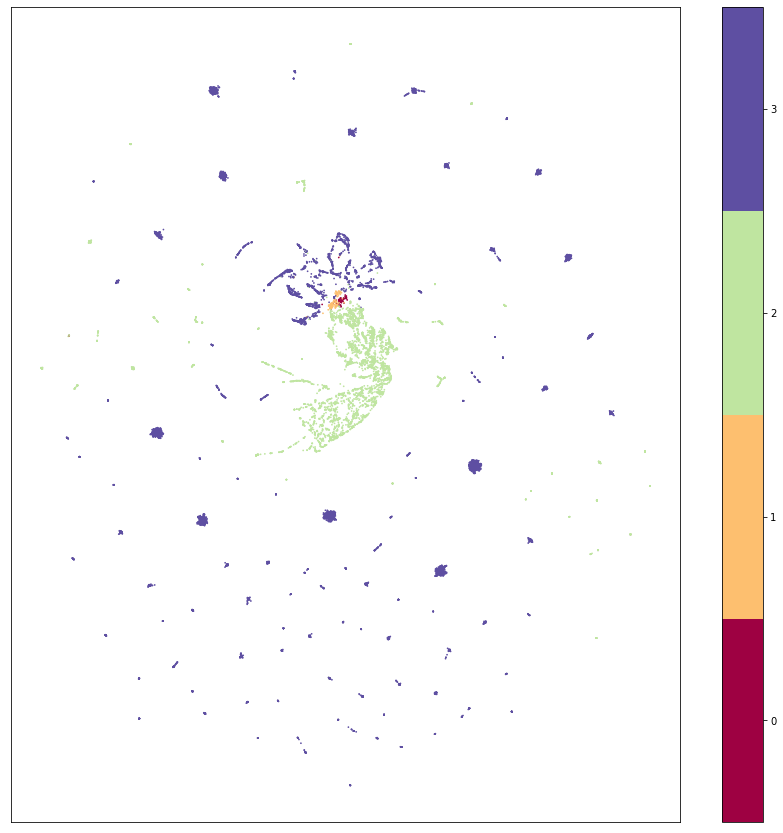

In [45]:
fig2, ax2 = plt.subplots(1, figsize = (15, 15))
plt.scatter(*embeddingSim.T, s = 0.5, c = targetSim, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax2, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(5) - 0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classesSim)

In [46]:
totalDF = [pltDF, pltSimDF]
totalDF = pd.concat(totalDF)

In [47]:
totalDF
tmpTotal = totalDF.drop(columns = 'Source')

In [48]:
targetTotal = np.array(totalDF.Source, dtype = np.str)
leTotal = LabelEncoder()
targetTotal = leTotal.fit_transform(targetTotal)
classesTotal = ['HighDose', 'LowDose', 'Tumor', 'Veh', 'SimHighDose', 'SimLowDose', 'SimTumor', 'SimVeh']

In [49]:
%%time
embeddingTotal = umap.UMAP(n_neighbors = 15).fit_transform(tmpTotal, y = targetTotal)

CPU times: user 14min, sys: 8min 58s, total: 22min 58s
Wall time: 1min 36s


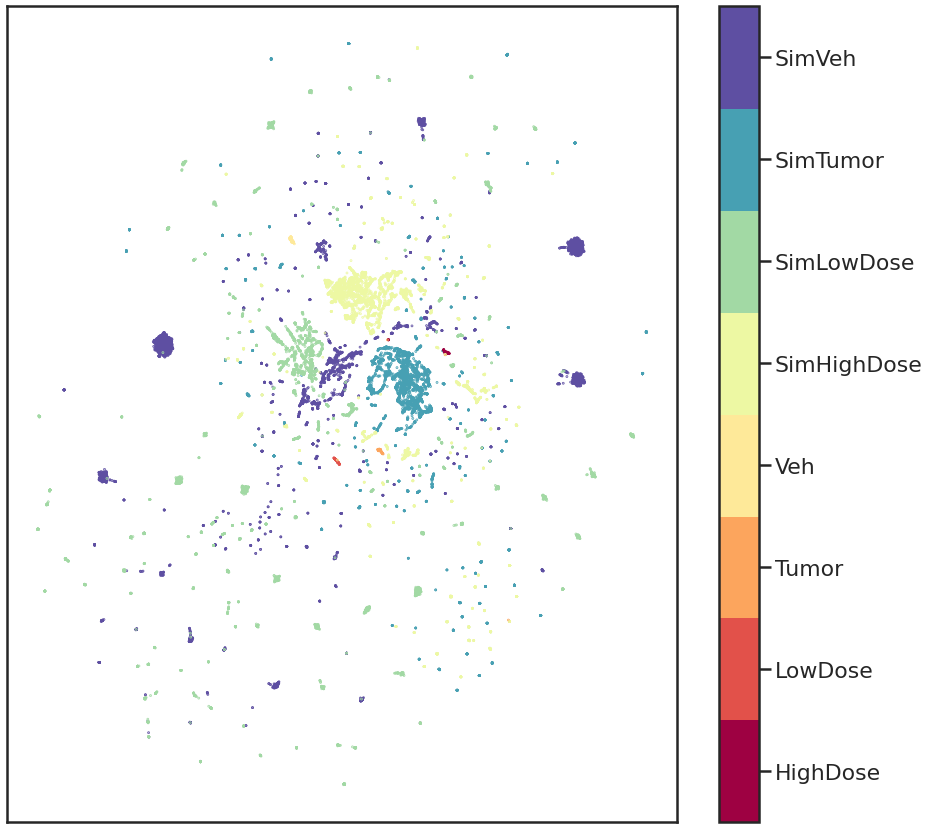

In [50]:
sns.set(style='white', context='poster')
fig, ax3 = plt.subplots(1, figsize = (15, 15))
plt.scatter(*embeddingTotal.T, s = 0.5, c = targetTotal, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax3, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(9) - 0.5)
cbar.set_ticks(np.arange(8))
cbar.set_ticklabels(classesTotal)

In [51]:
cdf = cudf.DataFrame.from_pandas(tmpTotal)
cutarget = cudf.Series(targetTotal)

In [52]:
embeddingTotal[ : , 1]

array([16.541626 ,  2.5676422, 17.79611  , ...,  1.9507681, -0.6920148,
        5.594026 ], dtype=float32)

In [53]:
%%time
cuTotalEmbedding = clUMAP(n_neighbors = 15, min_dist = 0, spread = 0.21, random_state = 42, verbose = True).fit_transform(cdf, y = cutarget)

/home/lima/miniconda3/envs/CONENV/lib/python3.7/site-packages/scipy/optimize/minpack.py:463: RuntimeWarning: divide by zero encountered in power
  return func(xdata, *params) - ydata


CPU times: user 2.1 s, sys: 326 ms, total: 2.43 s
Wall time: 3.57 s


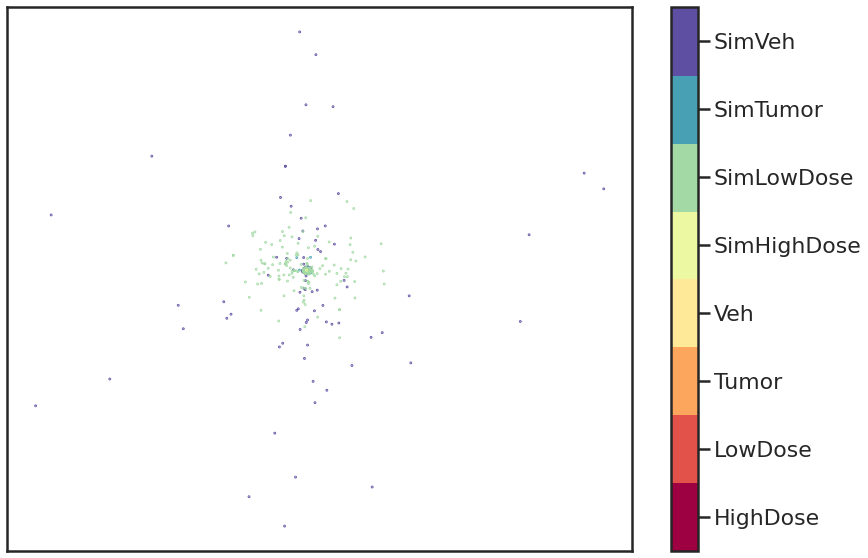

In [54]:
cuEmbedding = cuTotalEmbedding.to_pandas().values
sns.set(style='white', context='poster')
fig, ax4 = plt.subplots(1, figsize = (14, 10))
plt.scatter(cuEmbedding[ : , 1], cuEmbedding[ : , 0], s = 0.6, c = targetTotal, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax4, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(9) - 0.5)
cbar.set_ticks(np.arange(8))
cbar.set_ticklabels(classesTotal)

In [189]:
NumLabel

array([ 0,  3,  0, ..., 11,  9,  9])

In [4]:
cdf = cudf.from_pandas(df)

In [5]:
km_cdf = cdf.drop(['GeneID'])

In [6]:
pca = cuPCA(n_components = 2, svd_solver = 'full', whiten = False, random_state = 42)

In [7]:
%%time
output_pca = pca.fit_transform(km_cdf)

CPU times: user 419 ms, sys: 83.5 ms, total: 503 ms
Wall time: 502 ms


In [8]:
%%time
kmeans = cuKM(init = 'k-means||', n_clusters = 26, random_state = 42)
kmeans.fit(output_pca)

CPU times: user 327 ms, sys: 0 ns, total: 327 ms
Wall time: 326 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f3284ab6f70>, n_clusters=26, max_iter=300, tol=0.0001, verbose=0, random_state=42, init='k-means||', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [9]:
y_kmeans = kmeans.predict(output_pca)

In [10]:
output_pca['Predict'] = y_kmeans

In [11]:
pd_pca = output_pca.to_pandas().values

In [12]:
pd_pca = pd.DataFrame(pd_pca, columns = ['PC1', 'PC2', 'Predict'])

[]

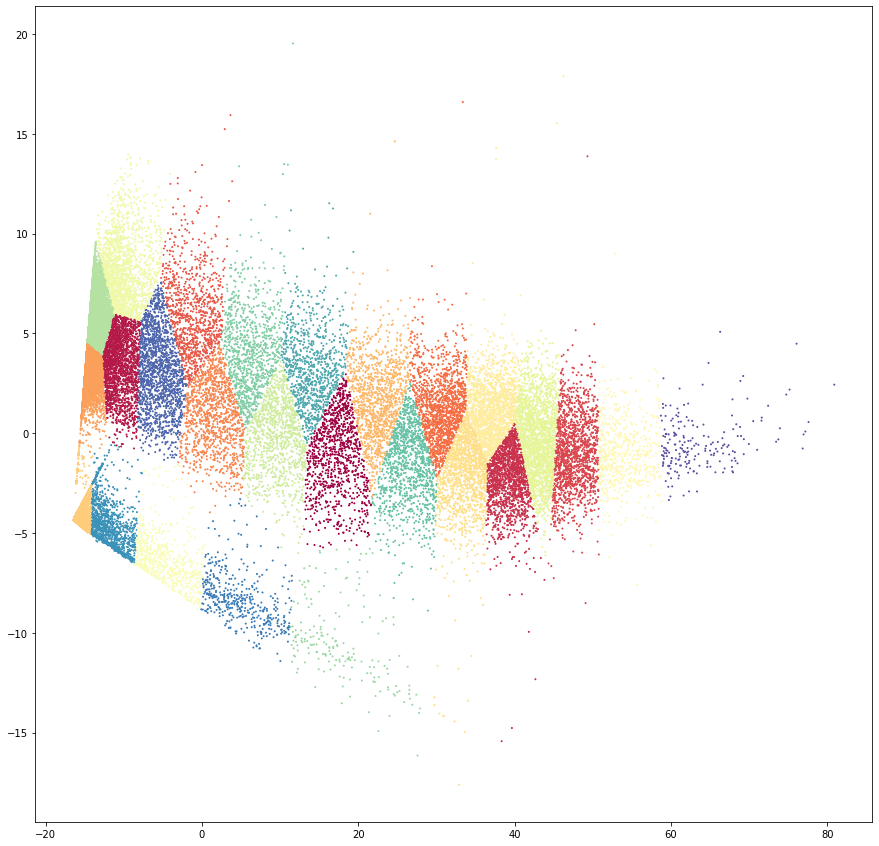

In [13]:
plt.figure(figsize = (15, 15))
plt.scatter(pd_pca.PC1, pd_pca.PC2, c = pd_pca.Predict, s = 1, cmap = 'Spectral')
plt.plot()

In [14]:
%%time
kmeans = cuKM(init = 'k-means||', n_clusters = 4, random_state = 42)
kmeans.fit(output_pca)

CPU times: user 21.4 ms, sys: 3.07 ms, total: 24.5 ms
Wall time: 23.3 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f3284ab6ed0>, n_clusters=4, max_iter=300, tol=0.0001, verbose=0, random_state=42, init='k-means||', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [15]:
y_kmeans = kmeans.predict(output_pca)

In [16]:
output_pca['Predict'] = y_kmeans

In [17]:
pd_pca = output_pca.to_pandas().values

In [18]:
pd_pca = pd.DataFrame(pd_pca, columns = ['PC1', 'PC2', 'Predict'])

[]

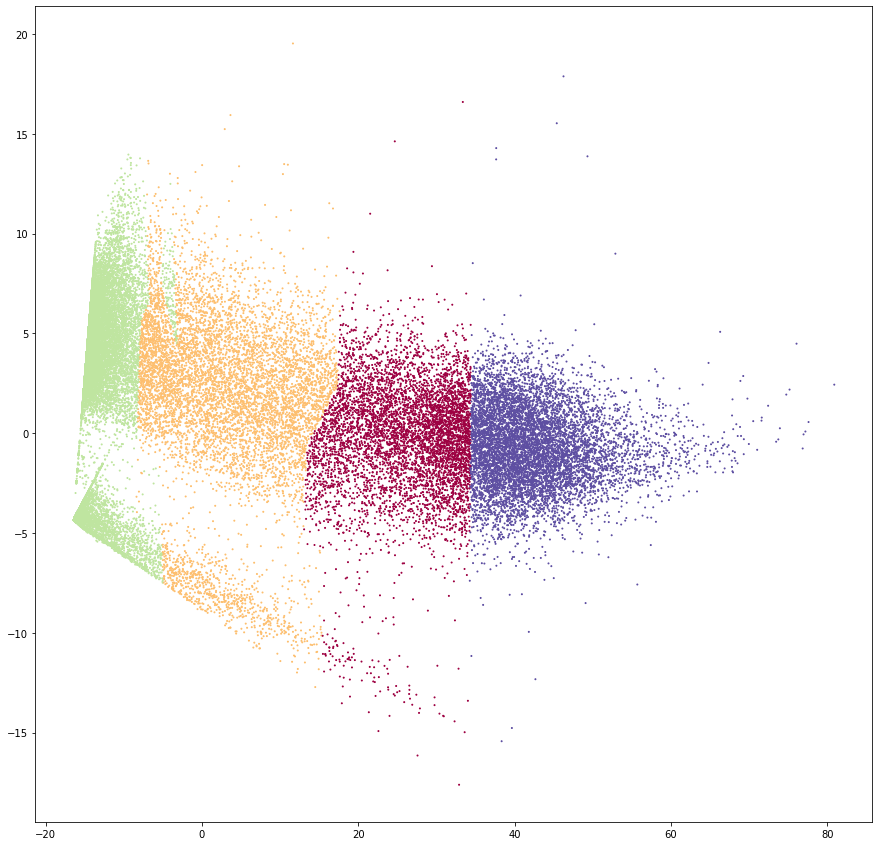

In [19]:
plt.figure(figsize = (15, 15))
plt.scatter(pd_pca.PC1, pd_pca.PC2, c = pd_pca.Predict, s = 1, cmap = 'Spectral')
plt.plot()

In [20]:
%%time
kmeans = cuKM(init = 'k-means||', n_clusters = 2, random_state = 42)
kmeans.fit(output_pca)

CPU times: user 24.1 ms, sys: 14.8 ms, total: 38.9 ms
Wall time: 38.8 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f32844b8c10>, n_clusters=2, max_iter=300, tol=0.0001, verbose=0, random_state=42, init='k-means||', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [21]:
y_kmeans = kmeans.predict(output_pca)

In [22]:
output_pca['Predict'] = y_kmeans

In [23]:
pd_pca = output_pca.to_pandas().values

In [24]:
pd_pca = pd.DataFrame(pd_pca, columns = ['PC1', 'PC2', 'Predict'])

[]

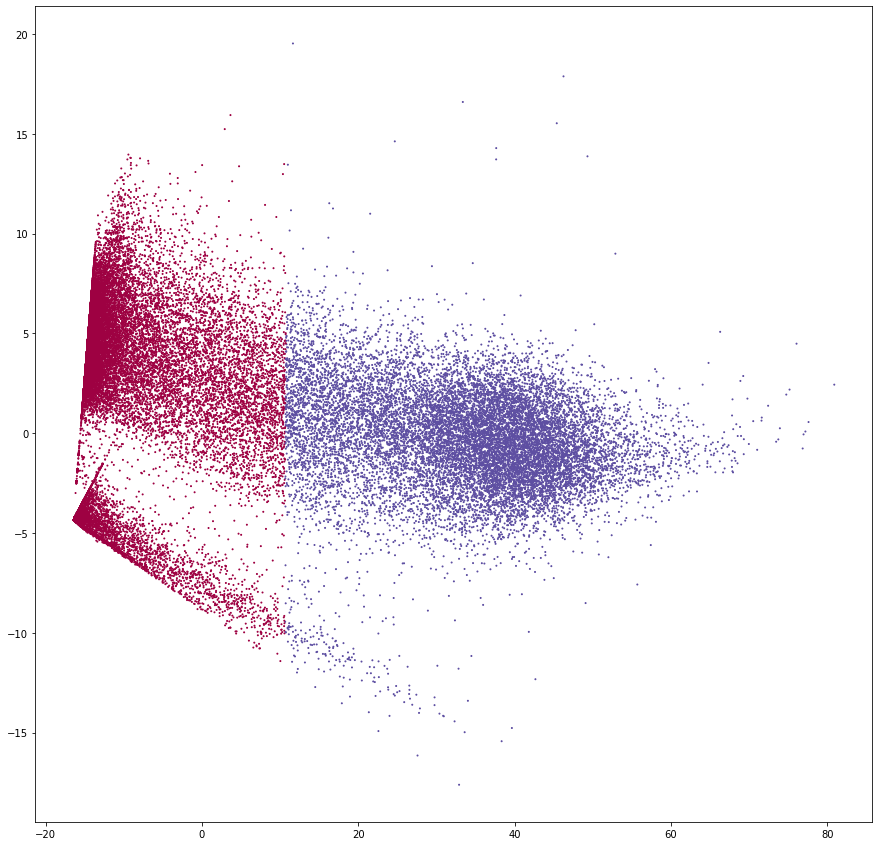

In [25]:
plt.figure(figsize = (15, 15))
plt.scatter(pd_pca.PC1, pd_pca.PC2, c = pd_pca.Predict, s = 1, cmap = 'Spectral')
plt.plot()